Lost Deliveries Impact Model 
--

1. Use first 28 days to get features, label should be from the next 28 days.
2. 28 days should not use the same start and end day for different users, the first day of the 28 days is the first time we observe a session from the user, then 28 days from this day.
3. When using Lasso, the features need to be normalized.
4. A classifiction model first, churned vs active.

V2.2
  - Important analysis and insights
  - Clear users with no true lost delivery
  - Need to add control for visit: people visiting less naturally have a higher churn rate.
  - Zone difference is not obvious.
  - **The implicit churn rate and implicit lost_true_d_visit for customers with different visits is surprising.**
    - Definitely need to have 'visit' as control/feture. 
    
V3.0
  - Clear session when the user type is "New".
  
V4.0: Positive Result, 0.1 DeltaLd ~ -0.1 Visit
  - In V3.0:
    - user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit'] * 28
    - user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit'] * 28
  - Here:
    - user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit']
    - user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit']
  - Correct a bug caused by join user_zones.
  
V5.0
  - Do the following transformation for lost_estimate in not converted.
    - To 0.0025: 0, to 0.047: 1, to 0.0755: 2, to 0.1038: 3, others: 4.
    
V5.1
  - Same as V5.0, use deltaOrder as label.
  
V5.1.1
  - Same as V5.1, but use the following for training and testing data:
  ```
  data = df[(df['user_type'] == user_type_model)\
          & (df['lost_true_scale_d_visit'].notnull())]
  ```
  instead of 
  ```
  data = df[(df['user_type'] == user_type_model)\
          & (df['lost_estimate'] > 0)\
          & (df['lost_true'].notnull())]
  ```

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
import statsmodels.api as sm
from datetime import datetime, timedelta
import pickle

%matplotlib inline

In [2]:
# Read in 28 days LDs and Orders
df_lds_orders_201809 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20180903_20180930.pkl')

df_lds_orders_201810 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20181001_20181028.pkl')

df_lds_orders_201811 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/lds_orders_20181029_20181125.pkl')

# Read in user infos for users in this 28 days
user_infos = pd.read_pickle(\
'/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/user_info_20180903_20180930.pkl')

# Read in zone average demand for the period.
df_zones = pd.read_csv('../../../data/20180903 Zone_Average_Deliveries.csv')
df_zones.rename(columns={'ZONE_ID':'zone_id', 'DEMAND':'demand'}, inplace=True)

## Functions, Variables, etc.

In [3]:
user_type_map = {'new': 1, 'non_express': 2, 'free_express': 3, 'discount_express': 4, 'paid_express': 5}
user_type_map_reverse = {v:k for k,v in user_type_map.items()}

def get_orders(df):
    # df[['user_id', 'date', 'converted']]
    
    orders_per_day = df[['user_id', 'date', 'converted']]\
        .groupby(['user_id', 'date']).sum().reset_index()

    orders = orders_per_day[orders_per_day['converted'] != 0][['user_id', 'date']]\
        .groupby(['user_id']).count().reset_index().rename(columns={'date': 'order'})
    
    return orders 

def get_visits(df):
    # df[['user_id', 'date']]
    
    unique_visits = df[['user_id', 'date']]\
        .drop_duplicates()

    visits = unique_visits.groupby(['user_id']).count().reset_index()\
        .rename(columns={'date':'visit'})
    
    return visits

def get_num_warehouse(df):
    # df[['user_id', 'warehouse_id']]
    
    num_warehouse = df[['user_id', 'warehouse_id']]\
        .drop_duplicates()
    
    num_warehouse = num_warehouse.groupby(['user_id']).count().reset_index()\
        .rename(columns={'warehouse_id':'num_warehouse'})
    
    return num_warehouse

## Get user ids for study.

In [4]:
# Get all the user_ids during 20180903-20180930.
# Get the corresponding first_date and last_date.
# The 28 days period is based on this first_date and last_date for each of the users.

user_ids = df_lds_orders_201809[['user_id', 'date']]\
    .groupby(['user_id']).min().reset_index()\
    .rename(columns={'date':'first_date'})
user_ids['last_date'] = user_ids['first_date'].map(lambda x: x + timedelta(days=28)) 
user_ids['label_date'] = user_ids['last_date'].map(lambda x: x + timedelta(days=28)) 

In [5]:
user_ids.head(5)

,user_id,first_date,last_date,label_date
0,11,2018-09-03,2018-10-01,2018-10-29
1,22,2018-09-07,2018-10-05,2018-11-02
2,52,2018-09-10,2018-10-08,2018-11-05
3,59,2018-09-14,2018-10-12,2018-11-09
4,60,2018-09-04,2018-10-02,2018-10-30


## Get DataFrame For The First 28 Days.

In [6]:
df_lds_orders = pd.concat([df_lds_orders_201809, df_lds_orders_201810])
df_lds_orders = user_ids.merge(df_lds_orders, on=['user_id'], how='left')
df_lds_orders = df_lds_orders[df_lds_orders['date'] < df_lds_orders['last_date']]

#### Clear sessions with user_type == 'new'

In [7]:
df_lds_orders = df_lds_orders[df_lds_orders['user_type'] != 'new'].copy()

### Check Data

In [8]:
df_lds_orders[df_lds_orders['user_id'] == 77][['user_id', 'date', 'last_date',\
              'hour', 'user_type', 'warehouse_id', 'metric_name', 
               'lost_estimate', 'converted']]

,user_id,date,last_date,hour,user_type,warehouse_id,metric_name,lost_estimate,converted
56,77,2018-09-12,2018-10-10,16,paid_express,3,lost_demand_precheckout,0.000000,False
57,77,2018-09-18,2018-10-10,5,paid_express,3,lost_demand_checkout,0.001170,True
58,77,2018-09-18,2018-10-10,5,paid_express,3,lost_demand_precheckout,0.065679,True
59,77,2018-09-22,2018-10-10,8,paid_express,53,lost_demand_checkout,0.009232,True
60,77,2018-09-22,2018-10-10,8,paid_express,3,lost_demand_precheckout,0.000000,True
61,77,2018-09-22,2018-10-10,8,paid_express,53,lost_demand_precheckout,0.000000,True
62,77,2018-09-27,2018-10-10,7,paid_express,53,lost_demand_precheckout,0.109320,False
63,77,2018-10-07,2018-10-10,15,paid_express,53,lost_demand_precheckout,0.000000,False
64,77,2018-10-08,2018-10-10,11,paid_express,53,lost_demand_precheckout,0.066558,False
65,77,2018-10-09,2018-10-10,11,paid_express,53,lost_demand_precheckout,0.000000,False


In [9]:
if False:
    tt = 'non_express'
    bound = 0.5
    t1 = len(df_lds_orders[df_lds_orders['user_type'] == tt])
    n1 = len(df_lds_orders[(df_lds_orders['lost_estimate'] > bound)\
                  & (df_lds_orders['user_type'] == tt)])
    print(n1 / float(t1))
    print(n1)
    print(t1)

## Feature Engineering For LDs and Orders

In [10]:
# Get user zones.
user_zones = df_lds_orders[['user_id', 'zone_id']].drop_duplicates()

# Get lost deliveries for this period.
user_lost_deliveries = df_lds_orders[['user_id', 'lost_estimate']]\
    .groupby('user_id').sum().reset_index()

# Exclude lost delivery estimate for visits that converted.
user_lost_true = df_lds_orders[df_lds_orders['converted'] == False]\
    [['user_id', 'lost_estimate']].groupby('user_id')\
    .sum().reset_index().rename(columns={'lost_estimate':'lost_true'})

# Get orders for this period.
user_orders = get_orders(df_lds_orders[['user_id', 'date', 'converted']])

# Get visits for the period.
user_visits = get_visits(df_lds_orders[['user_id', 'date']])

# Exclude visits that converted.
user_visit_lost = get_visits(df_lds_orders[df_lds_orders['converted'] == False]\
    [['user_id', 'date']].copy())
user_visit_lost.rename(columns={'visit':'visit_lost'}, inplace=True)

# Warehouse_id is unique and universal.
user_warehouse_daily_count = df_lds_orders[['user_id', 'date', 'warehouse_id']]\
    .drop_duplicates().groupby(['user_id', 'date']).count().reset_index()

user_warehouse_daily_average = user_warehouse_daily_count[['user_id', 'warehouse_id']]\
    .groupby('user_id').mean().reset_index().rename(columns={'warehouse_id':'warehouse_daily_avg'})

# Get the average visit interval days.
user_visit_feature = df_lds_orders[['user_id', 'date', 'last_date']]\
    .drop_duplicates().sort_values(by=['user_id', 'date'])
user_visit_feature['lag1'] = user_visit_feature.groupby('user_id')['date'].shift(-1)

t = (user_visit_feature['lag1'] - user_visit_feature['date']).map(lambda x: x.days)
t2 = (user_visit_feature['last_date'] - user_visit_feature['date']).map(lambda x: x.days)
t3 = pd.DataFrame({'lag':t, 'last_lag':t2})
user_visit_feature['visit_interval'] = t3.min(axis=1)

user_avg_visit_feature = user_visit_feature[['user_id', 'visit_interval']]\
    .groupby('user_id').median().reset_index()

# About 7% of users have two user_types.
# User type at the beginning of the period
user_first_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).min().reset_index()
user_type_first = user_first_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_first['user_type'] = user_type_first['user_type'].map(lambda x: user_type_map[x])
user_type_first = user_type_first.groupby('user_id').max().reset_index()

user_type_first_count = user_type_first.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_first'}).reset_index()
user_type_first_count['user_type'] = user_type_first_count['user_type'].map(lambda x: user_type_map_reverse[x])

# User type at the end of the period
user_last_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).max().reset_index()
user_type_last = user_last_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_last['user_type'] = user_type_last['user_type'].map(lambda x: user_type_map[x])
user_type_last = user_type_last.groupby('user_id').max().reset_index()

user_type_last_count = user_type_last.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_last'}).reset_index()
user_type_last_count['user_type'] = user_type_last_count['user_type'].map(lambda x: user_type_map_reverse[x])

user_type_count = user_type_first_count\
    .merge(user_type_last_count, on=['user_type'])

# Get the number of warehouse during the period.
user_num_warehouse = get_num_warehouse(df_lds_orders[['user_id', 'warehouse_id']])

# Give a weight for the lost_estimate
user_lost_lag = df_lds_orders[['user_id', 'last_date', 'date', 'lost_estimate']].\
    groupby(['user_id', 'last_date', 'date']).sum().reset_index()

user_lost_lag['lost_weight'] = user_lost_lag['lost_estimate'] * \
    (29 - (user_lost_lag['last_date'] - user_lost_lag['date']).map(lambda x: x.days)) / 28

user_lost_lag = user_lost_lag[['user_id', 'lost_weight']].\
    groupby('user_id').sum().reset_index().rename(columns={'lost_weight':'lost_lag'})

# Merge all the DataFrame after feature engineering.
user_df = user_lost_deliveries.merge(user_orders, on=['user_id'], how='left')
user_df = user_df.merge(user_visits, on=['user_id'], how='left')
user_df = user_df.merge(user_warehouse_daily_average, on=['user_id'], how='left')
user_df = user_df.merge(user_avg_visit_feature, on='user_id', how='left')
user_df = user_df.merge(user_num_warehouse, on=['user_id'], how='left')
user_df = user_df.merge(user_type_last, on='user_id', how='left')\
    .fillna(value={'order': 0})
user_df = user_df.merge(user_lost_lag, on='user_id', how='left')
user_df = user_df.merge(user_visit_lost, on='user_id', how='left')
user_df = user_df.merge(user_lost_true, on='user_id', how='left')

#### Use cutoff to convert lost_estimate

  - Do the following transformation for lost_estimate in not converted.
    - To 0.0025: 0, to 0.047: 1, to 0.0755: 2, to 0.1038: 3, others: 4.

In [11]:
# Get lost_estimate for each visit: add pre-checkout and checkout lost_estimate.
lost_calculation = df_lds_orders[['user_id', 'date', 'hour',\
                                 'warehouse_id', 'converted', 'lost_estimate',]]\
    .groupby(['user_id', 'date', 'hour', 'warehouse_id', 'converted']).sum()\
    .reset_index()
lost_calculation = lost_calculation.merge(user_type_last, on='user_id', how='left')

lost_sum = lost_calculation[['user_id', 'user_type', 'converted', 'lost_estimate']]\
    .groupby(['user_id', 'user_type', 'converted']).sum().reset_index()

# Get all the not converted ones. 
user_lost_scale = lost_calculation[lost_calculation['converted'] == False].copy()
user_lost_scale['lost_true_scale'] = user_lost_scale['lost_estimate']\
    .map(lambda x: 0 if x < 0.0025\
                     else 1 if x < 0.047\
                     else 2 if x < 0.0755\
                     else 3 if x < 0.1038\
                     else 4)
user_lost_scale_sum = user_lost_scale[['user_id', 'lost_true_scale']]\
    .groupby(['user_id']).sum().reset_index()

In [12]:
# Keep the null ones as null.
user_df = user_df.merge(user_lost_scale_sum, on='user_id', how='left')

#### Interaction Features

In [13]:
import math
user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit']
user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit']
user_df['lost_true_scale_d_visit'] = user_df['lost_true_scale'] / user_df['visit'].astype('float')

### Explore total lost_delivery

In [14]:
if True:
    tt = 2
    bound = 0.5
    t1 = len(user_df[user_df['user_type'] == tt])
    n1 = len(user_df[(user_df['lost_true_d_visit'] > bound)\
                  & (user_df['user_type'] == tt)])
    print(n1 / float(t1))
    print(n1)
    print(t1)

0.000556631140377
435
781487


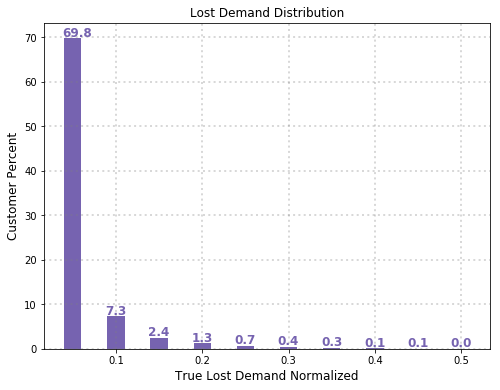

In [15]:
bound = 0.5
ind_width = round(bound / float(25), 3)

x = [(i + 1) * bound / 10 for i in range(10)]

tot = len(user_df)
y0, division0 = np.histogram(user_df[user_df['lost_true_d_visit'] <= bound]\
                             ['lost_true_d_visit'])
y = [i / float(tot) * 100 for i in y0]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#7663b0', width=ind_width)
ax1.set_xlabel('True Lost Demand Normalized',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Lost Demand Distribution')
for i, v in enumerate(y):
    ax1.text((i + 0.75) * bound / 10, v + 0.5, str(round(v, 1)),\
             color='#7663b0', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost Delivery Session Calculation.png')
plt.show()

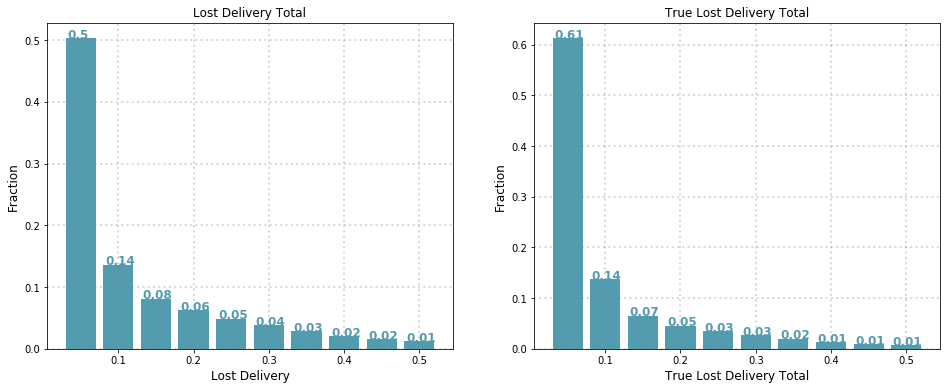

In [16]:
ind_width = 0.04

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

tot = len(user_df)
y0, division0 = np.histogram(user_df[user_df['lost_estimate'] <= 0.5]\
                             ['lost_estimate'])
y = [i / float(tot) for i in y0]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x, y, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Lost Delivery',fontsize=12)
ax1.set_ylabel('Fraction',fontsize=12)
ax1.set_title('Lost Delivery Total')
for i, v in enumerate(y):
    ax1.text( (i + 0.65) * 0.05, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

tot2 = len(user_df[user_df['lost_true'].notnull()])
y1, division1 = np.histogram(user_df[(user_df['lost_true'] <= 0.5)\
                                     & (user_df['lost_true'].notnull())]\
                             ['lost_true'])
y2 = [i / float(tot2) for i in y1]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('True Lost Delivery Total',fontsize=12)
ax2.set_ylabel('Fraction',fontsize=12)
ax2.set_title('True Lost Delivery Total')
for i, v in enumerate(y2):
    ax2.text( (i + 0.64) * 0.05, v, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Total Lost Delivery Calculation.png')
plt.show()

## Examine lost_delivery_model

In [17]:
tot_lost_N = len(lost_sum[(lost_sum['converted'] == False)])
bound = 0.256
print(len(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['lost_estimate'] <= bound)]) / float(tot_lost_N))

0.900368027281


467540 is Converted and 638851 is Not Converted.


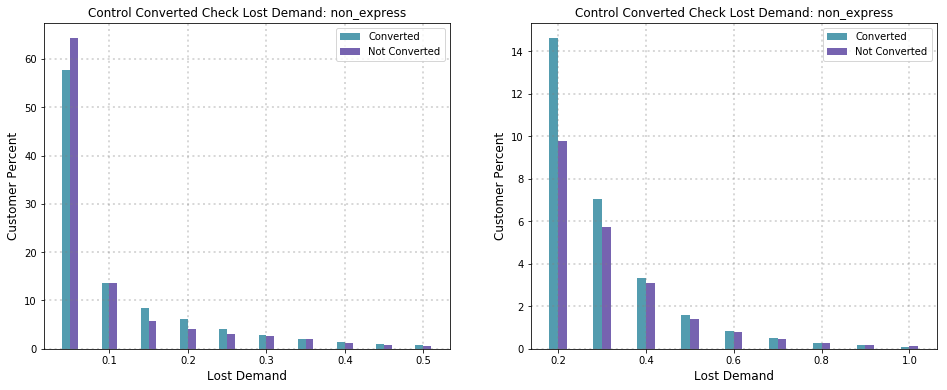

In [18]:
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

ttt_type = 2

tot_1 = len(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)]) 
y1, division1 = np.histogram(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 0.5)]['lost_estimate'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)]) 
y2, division2 = np.histogram(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 0.5)]['lost_estimate'])
y2 = [i / float(tot_2) * 100 for i in y2]
            
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x1, y1, align='center', color='#539caf',label='Converted', width=0.01)
ax1.bar(x2, y2, align='center', color='#7663b0', label='Not Converted', width=0.01)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Control Converted Check Lost Demand: '\
              + user_type_map_reverse[ttt_type])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)


x0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x3 = [a - 0.01 for a in x0]
x4 = [a + 0.01 for a in x0]

y3, division3 = np.histogram(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 1.0)]['lost_estimate'])
y3 = [i / float(tot_1) * 100 for i in y3]

y4, division4 = np.histogram(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 1.0)]['lost_estimate'])
y4 = [i / float(tot_2) * 100 for i in y4]
            
ax2 = fig.add_subplot(122)
ax2.bar(x3[1:], y3[1:], align='center', color='#539caf',label='Converted', width=0.02)
ax2.bar(x4[1:], y4[1:], align='center', color='#7663b0', label='Not Converted', width=0.02)
ax2.set_xlabel('Lost Demand',fontsize=12)
ax2.set_ylabel('Customer Percent',fontsize=12)
ax2.set_title('Control Converted Check Lost Demand: '\
              + user_type_map_reverse[ttt_type])
ax2.legend(loc = 'upper right',fontsize=10)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost For Converted Or Not '\
            + user_type_map_reverse[ttt_type]\
            + '.png')
print('%6d is Converted and %6d is Not Converted.'%(tot_1, tot_2))
plt.show()

## Get DataFrame For The Second 28 Days.

In [19]:
df_labels = pd.concat([df_lds_orders_201810, df_lds_orders_201811])
df_labels = user_ids.merge(df_labels, on=['user_id'], how='left')
df_labels = df_labels[(df_labels['date'] >= df_labels['last_date'])\
                      & (df_labels['date'] < df_labels['label_date'])]

## Feature Engineers For Labels

In [20]:
# Get orders for this period.
label_orders = get_orders(df_labels[['user_id', 'date', 'converted']])

# Get visits for the period, visit per day is 0 or 1.
label_visits = get_visits(df_labels[['user_id', 'date']])

label_df = user_ids.merge(label_visits, on=['user_id'], how='left')
label_df = label_df.merge(label_orders, on=['user_id'], how='left')

label_df = label_df.rename(columns={'visit':'label_visit', 'order':'label_order'})\
    .drop(columns=['first_date', 'last_date', 'label_date'], axis=1)
label_df.fillna(value={'label_visit': 0, 'label_order':0}, inplace=True)

In [21]:
label_df.head(5)

,user_id,label_visit,label_order
0,11,0.0,0.0
1,22,5.0,0.0
2,52,2.0,0.0
3,59,0.0,0.0
4,60,2.0,1.0


### Join Features and Labels Together

In [22]:
df_explore = user_df.merge(label_df, on=['user_id'], how='left')
df_explore['lost_d_visit'] = df_explore['lost_estimate'] / df_explore['visit']
df_explore['lost_true_d_visit'] = df_explore['lost_true'] / df_explore['visit']

## User Statistics

In [23]:
user_type_count

,user_type,count_first,count_last
0,non_express,759174,781487
1,free_express,208758,175455
2,discount_express,1195,1167
3,paid_express,333259,344277


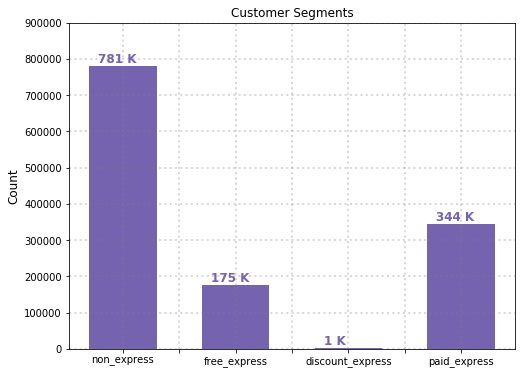

In [24]:
x = [1,2,3,4]
x1 = [a - 0.2 for a in x]
x2 = [a + 0.2 for a in x]
y1 = user_type_count.count_first.tolist()
y2 = user_type_count.count_last.tolist()
ind_width = 0.6

fig, ax = plt.subplots(figsize=(8,6))
#ax.bar(x1, y1, align='center', color='#539caf',label='Beginning', width=ind_width)
ax.bar(x, y2, align='center', color='#7663b0', width=ind_width)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Customer Segments')
ax.set_ylim([0, 900000])
for i, v in enumerate(y2):
    ax.text(i + 0.78, v + 10000, str(int(v/1000)) + ' K', color='#7663b0', fontweight='bold', fontsize=12)
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.set_xticklabels(('', 'non_express', '', 'free_express', '',\
                    'discount_express', '', 'paid_express'))
plt.savefig('20180903-20180930 User Type Changes.png')
plt.show()

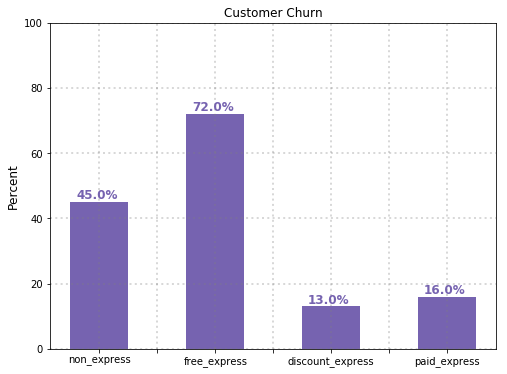

In [25]:
x = [1,2,3,4]
y1 = user_type_count.count_last.tolist()
t = label_df.merge(user_type_last, on=['user_id'], how='left')
y2 = t[t['label_visit'] != 0][['user_type',\
        'label_visit']].groupby('user_type').count().label_visit.tolist()
y3 = [round(1 - i / float(j), 2)*100 for i, j in zip(y2, y1)]

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, y3, align='center',\
       color='#7663b0', width=0.5)
#ax.set_xlabel('Customer Type',fontsize=12)
ax.set_ylabel('Percent',fontsize=12)
for i, v in enumerate(y3):
    ax.text(i + 0.8, v + 1, str(v) + '%', color='#7663b0', fontweight='bold', fontsize=12)
ax.set_ylim([0,100])
ax.set_title('Customer Churn')
ax.set_xticklabels(('', 'non_express', '','free_express', '', 'discount_express','', 'paid_express'))
plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig('20180903-20180930 User Churned.png')
plt.show()

## User Orders Per Type

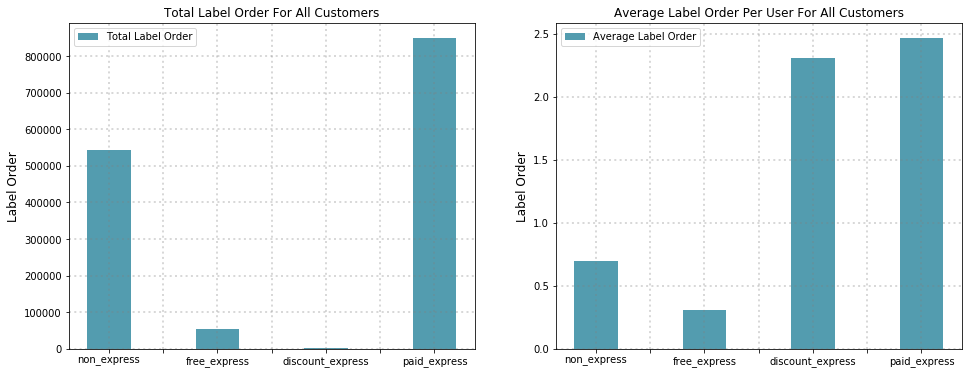

In [26]:
user_order_per_type = df_explore[['user_type', 'label_order']].groupby(['user_type']).sum().reset_index()
user_order_per_type['user_type'] = user_order_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4]
y1 = user_order_per_type.label_order.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Label Order', width=ind_width)
#ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Label Order',fontsize=12)
ax.set_title('Total Label Order For All Customers')
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.legend(loc = 'upper left',fontsize=10)
ax.set_xticklabels(('', 'non_express', '',\
                    'free_express', '','discount_express', '', 'paid_express'))

y2 = [i/j for i, j in zip(user_order_per_type.label_order.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Label Order', width=ind_width)
#ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Label Order',fontsize=12)
ax2.set_title('Average Label Order Per User For All Customers')
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'non_express', '',\
                     'free_express', '', 'discount_express', '', 'paid_express'))
plt.savefig('20180903-20180930 User Orders Per Type.png')
plt.show()

## User Lost Deliveries Per Type

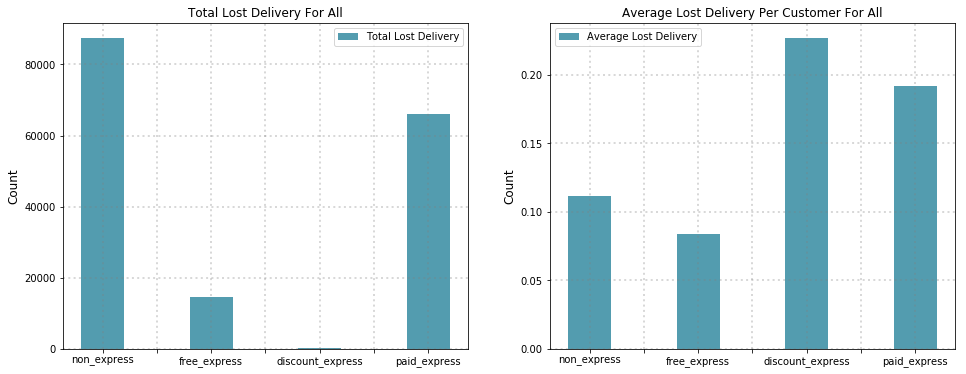

In [27]:
user_lost_per_type = user_df[['user_type', 'lost_estimate']].groupby(['user_type']).sum().reset_index()
user_lost_per_type['user_type'] = user_lost_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4]
y1 = user_lost_per_type.lost_estimate.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Lost Delivery', width=ind_width)
#ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Total Lost Delivery For All')
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.legend(loc = 'upper right',fontsize=10)
ax.set_xticklabels(('', 'non_express', '',\
                     'free_express', '', 'discount_express', '', 'paid_express'))

y2 = [i/j for i, j in zip(user_lost_per_type.lost_estimate.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Lost Delivery', width=ind_width)
#ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Count',fontsize=12)
ax2.set_title('Average Lost Delivery Per Customer For All')
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'non_express', '',\
                     'free_express', '', 'discount_express', '', 'paid_express'))
plt.savefig('20180903-20180930 User Lost Deliveries Per Type.png')
plt.show()

## User Visit Per Type

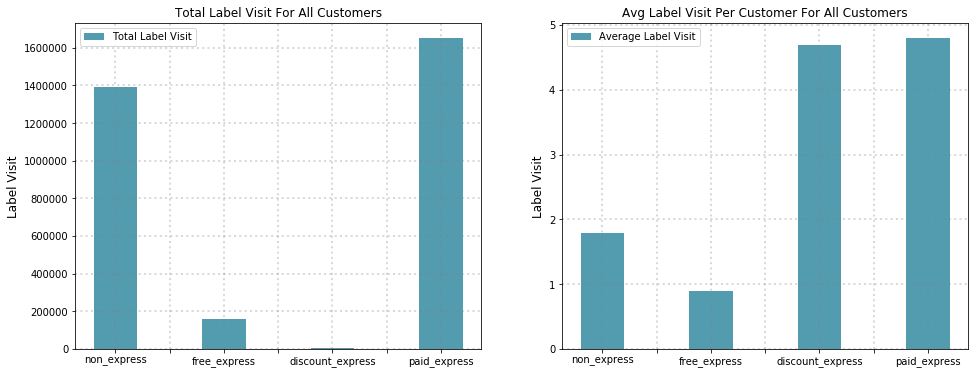

In [28]:
user_visit_per_type = df_explore[['user_type', 'label_visit']].groupby(['user_type']).sum().reset_index()
user_visit_per_type['user_type'] = user_visit_per_type['user_type'].map(lambda x: user_type_map_reverse[x])

x = [1,2,3,4]
y1 = user_visit_per_type.label_visit.tolist()
ind_width = 0.4

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.bar(x, y1, align='center', color='#539caf',label='Total Label Visit', width=ind_width)
#ax.set_xlabel('User Type',fontsize=12)
ax.set_ylabel('Label Visit',fontsize=12)
ax.set_title('Total Label Visit For All Customers')
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
#ax.set_ylim([0, 2850000])
ax.legend(loc = 'upper left',fontsize=10)
ax.set_xticklabels(('', 'non_express', '',\
                     'free_express', '', 'discount_express', '', 'paid_express'))

y2 = [i/j for i, j in zip(user_visit_per_type.label_visit.tolist(), user_type_count.count_last.tolist())]
ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf',label='Average Label Visit', width=ind_width)
#ax2.set_xlabel('User Type',fontsize=12)
ax2.set_ylabel('Label Visit',fontsize=12)
ax2.set_title('Avg Label Visit Per Customer For All Customers')
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.legend(loc = 'upper left',fontsize=10)
ax2.set_xticklabels(('', 'non_express', '',\
                     'free_express', '', 'discount_express', '', 'paid_express'))
plt.savefig('20180903-20180930 User Visits Per Type.png')
plt.show()

## About User Statistics Of Orders, Visits, Warehouse and Lost Deliveries

We don't need to consider new users in our model since new users almost all have one visit and 0 orders.

In [29]:
# What threshold to use to get good histogram.

k = 5
label = 'lost_estimate'
t_tot = float(len(df_explore[df_explore['user_type'] == k]))
t2 = df_explore[(df_explore['user_type'] == k)\
                & (df_explore[label] >= 0)\
               & (df_explore[label] < 0.1)][label]
count2, division2 = np.histogram(t2)
count2 = [round(i / t_tot, 3) * 100 for i in count2]
sum(count2)

52.30000000000001

In [30]:
user_stats = {}

for k in [2, 3, 4, 5]:
    
    t_tot = float(len(user_df[user_df['user_type'] == k]))
    
    t1 = user_df[(user_df['user_type'] == k) & (user_df['lost_estimate'] <= 0.5)]['lost_estimate']
    count1, division1 = np.histogram(t1)
    count1 = [round(i / t_tot, 3) * 100 for i in count1]

    t2 = user_df[(user_df['user_type'] == k) & (user_df['order'] <= 10)]['order']
    count2, division2 = np.histogram(t2)
    count2 = [round(i / t_tot, 3) * 100 for i in count2]

    t3 = user_df[(user_df['user_type'] == k) & (user_df['visit'] <= 11)]['visit']
    count3, division3 = np.histogram(t3)
    count3 = [round(i / t_tot, 3) * 100 for i in count3]

    t4 = user_df[(user_df['user_type'] == k) & (user_df['warehouse_daily_avg'] <= 6)]['warehouse_daily_avg']
    count4, division4 = np.histogram(t4)
    count4 = [round(i / t_tot, 3) * 100 for i in count4]
    
    t5 = df_explore[(df_explore['user_type'] == k) & (df_explore['label_visit'] <= 10)]['label_visit']
    count5, division5 = np.histogram(t5)
    count5 = [round(i / t_tot, 3) * 100 for i in count5]
    
    t6 = df_explore[(df_explore['user_type'] == k) & (df_explore['label_order'] <= 10)]['label_order']
    count6, division6 = np.histogram(t6)
    count6 = [round(i / t_tot, 3) * 100 for i in count6]

    user_stats[user_type_map_reverse[k]] =pd.DataFrame({'Order': division2[:-1],
                                                        'OPct': count2,
                                                        'Visit': division3[:-1],
                                                        'VPct': count3,
                                                        'Lost': division1[:-1],
                                                        'LPct': count1,
                                                        'Warehouse': division4[:-1],
                                                        'WPct': count4,
                                                         'LVisit': division5[:-1],
                                                        'LVPct': count5,
                                                         'LOrder': division6[:-1],
                                                        'LOPct': count6,})
    user_stats[k] = user_stats[user_type_map_reverse[k]][['Order',\
                                           'OPct', 'Visit', 'VPct',\
                                           'Lost', 'LPct', \
                                            'LVisit', 'LVPct',\
                                            'LOrder', 'LOPct']]
    
    print('\nFor %s:'%(user_type_map_reverse[k]))
    print(user_stats[k])


For non_express:
   Order  OPct  Visit  VPct      Lost  LPct  LVisit  LVPct  LOrder  LOPct
0    0.0  40.2    1.0  35.5  0.000000  53.6     0.0   45.2     0.0   65.2
1    1.0  32.6    2.0  21.9  0.049998  13.6     1.0   18.4     1.0   17.7
2    2.0  14.2    3.0  13.8  0.099997   7.6     2.0   11.7     2.0    8.5
3    3.0   6.7    4.0   9.2  0.149995   5.8     3.0    7.6     3.0    4.3
4    4.0   3.3    5.0   6.0  0.199993   4.5     4.0    5.2     4.0    2.3
5    5.0   1.5    6.0   4.0  0.249991   3.7     5.0    3.5     5.0    1.0
6    6.0   0.7    7.0   2.7  0.299990   2.7     6.0    2.4     6.0    0.5
7    7.0   0.3    8.0   1.9  0.349988   1.8     7.0    1.7     7.0    0.3
8    8.0   0.2    9.0   1.3  0.399986   1.4     8.0    1.2     8.0    0.1
9    9.0   0.2   10.0   1.6  0.449984   1.0     9.0    1.4     9.0    0.1

For free_express:
   Order  OPct  Visit  VPct      Lost  LPct  LVisit  LVPct  LOrder  LOPct
0    0.0  46.4    1.0  45.8  0.000000  60.1     0.0   72.2     0.0   85.1
1

### Lost Delivery Status

Percent of customers with lost delivery greater than 1.

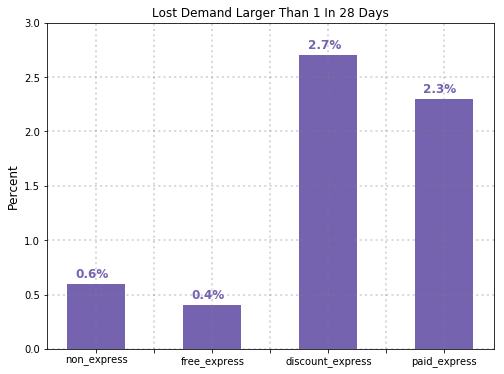

In [31]:
x = [1,2,3,4]
y = [0.6, 0.4, 2.7, 2.3]

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, y, align='center', color='#7663b0', width=0.5)
ax.set_ylabel('Percent', fontsize=12)
ax.set_ylim([0,3])
ax.set_title('Lost Demand Larger Than 1 In 28 Days')
ax.set_xticklabels(('', 'non_express', '','free_express', '', 'discount_express','', 'paid_express'))
for i, v in enumerate(y):
    ax.text(i + 0.82, v + 0.06, str(v) + '%', color='#7663b0', fontweight='bold', fontsize=12)
plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig('20180903-20180930 Lost Delivery Status.png')
plt.show()

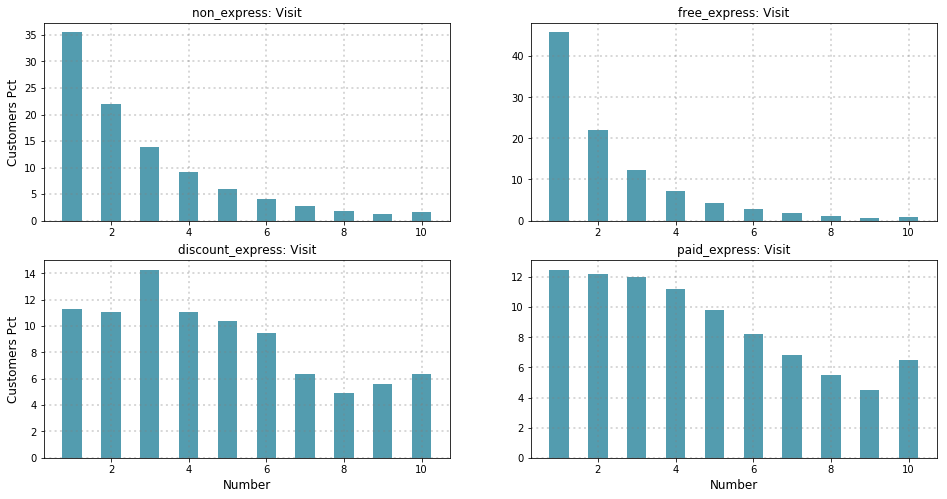

In [32]:
png_name = 'Customer Order Number'
label = 'Visit'
label_pct = 'VPct'

fig = plt.figure(figsize=(16, 8))

ax2 = fig.add_subplot(221)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.5)
ax2.set_title('non_express: ' + label)
ax2.set_ylabel('Customers Pct',fontsize=12)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax3 = fig.add_subplot(222)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.5)
ax3.set_title('free_express: ' + label)
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax4 = fig.add_subplot(223)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.5)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax4.set_title('discount_express: ' + label)

ax5 = fig.add_subplot(224)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.5)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

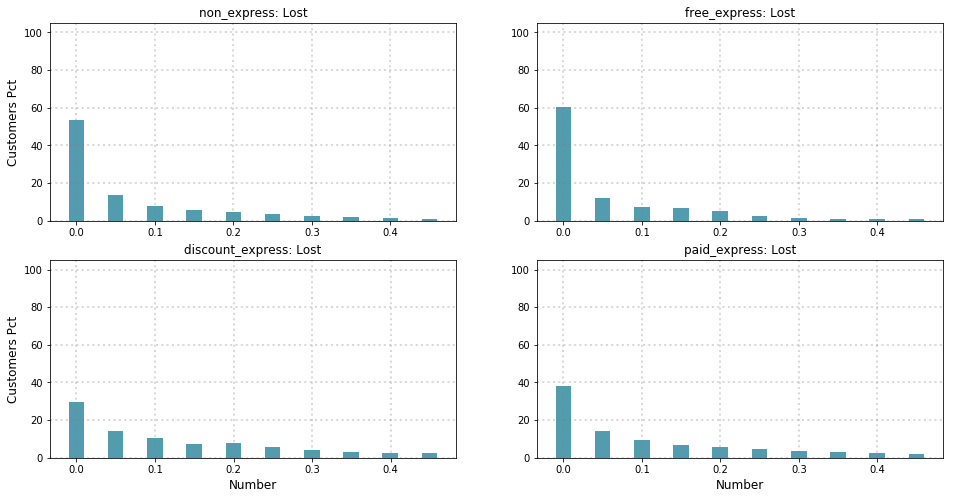

In [33]:
# For Lost
label = 'Lost'
label_pct = 'LPct'
png_name = 'Customer Lost Delivery Number'

fig = plt.figure(figsize=(16, 8))

ax2 = fig.add_subplot(221)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.02)
ax2.set_title('non_express: ' + label)
ax2.set_ylabel('Customers Pct',fontsize=12)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax2.set_ylim([0, 105])

ax3 = fig.add_subplot(222)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.02)
ax3.set_title('free_express: ' + label)
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax3.set_ylim([0, 105])

ax4 = fig.add_subplot(223)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.02)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.set_title('discount_express: ' + label)
ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax4.set_ylim([0, 105])

ax5 = fig.add_subplot(224)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.02)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax5.set_ylim([0, 105])

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

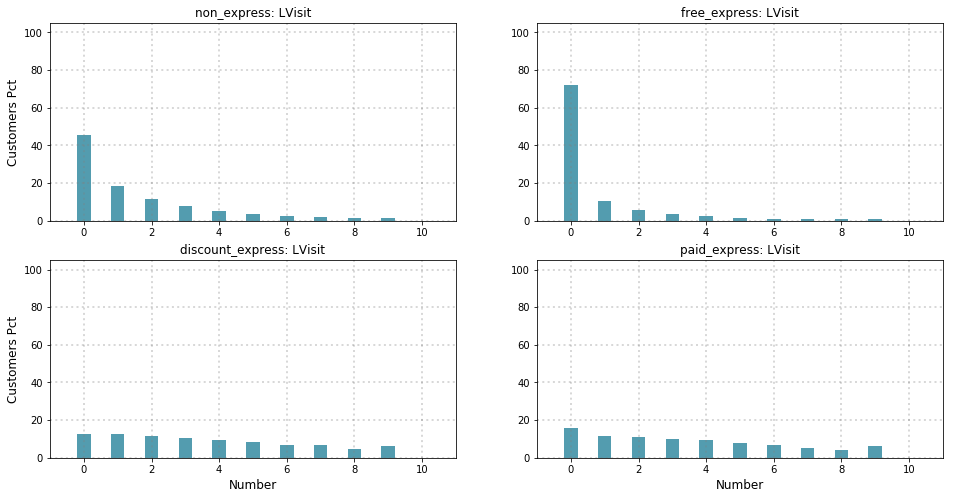

In [34]:
# For Label Visit
label = 'LVisit'
label_pct = 'LVPct'
png_name = 'Customer Visit'

fig = plt.figure(figsize=(16, 8))

ax2 = fig.add_subplot(221)
ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.4)
ax2.set_title('non_express: ' + label)
ax2.set_ylabel('Customers Pct',fontsize=12)
ax2.set_xlim([-1,11])
ax2.set_ylim([0, 105])
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax3 = fig.add_subplot(222)
ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.4)
ax3.set_title('free_express: ' + label)
ax3.set_xlim([-1,11])
ax3.set_ylim([0, 105])
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax4 = fig.add_subplot(223)
ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.4)
ax4.set_xlabel('Number',fontsize=12)
ax4.set_ylabel('Customers Pct',fontsize=12)
ax4.set_title('discount_express: ' + label)
ax4.set_xlim([-1,11])
ax4.set_ylim([0, 105])
ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax5 = fig.add_subplot(224)
ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.4)
ax5.set_xlabel('Number',fontsize=12)
ax5.set_title('paid_express: ' + label)
ax5.set_xlim([-1,11])
ax5.set_ylim([0, 105])
ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 ' + png_name + ' Distribution.png')
plt.show()

## Any Signal From Lost Deliveries With Label_Visit

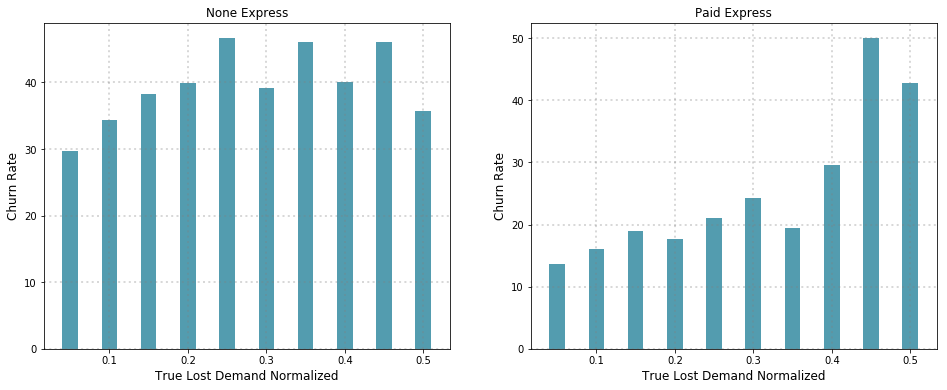

In [35]:
ind_width = 0.02
lower = 3
upper = 6
variable = 'lost_true_d_visit'
x_label = 'True Lost Demand Normalized'

fig = plt.figure(figsize=(16, 6))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

t_type1 = 2
y0, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type1)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= lower)
           & (df_explore['visit'] < upper)][variable])

y1, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type1)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= lower)
           & (df_explore['visit'] < upper)][variable])
y1 = [i / float(j) * 100 for i, j in zip(y1, y0)]

ax1 = fig.add_subplot(121)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel(x_label, fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
#ax1.set_ylim([0, 80])
ax1.set_title('None Express')
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

t_type2 = 5
y, division = np.histogram(df_explore[(df_explore['user_type'] == t_type2)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= lower)
           & (df_explore['visit'] < upper)][variable])

y3, division3 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type2)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= lower)
           & (df_explore['visit'] < upper)][variable])
y3 = [i / float(j) * 100 for i, j in zip(y3, y)]

ax2 = fig.add_subplot(122)
ax2.bar(x, y3, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel(x_label,fontsize=12)
ax2.set_ylabel('Churn Rate',fontsize=12)
ax2.set_title('Paid Express')
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost Deliveries vs Churn '\
            + str(lower) + '_' + str(upper) + '.png')
plt.show()

#### User stats

Number of Cusomters for None Express:
 - with only 1 visit (lost_true_d_visit < 0.5): 124,886
 - with 2 visits (lost_true_d_visit < 0.5): 103085
 - with 3 visits (lost_true_d_visit < 0.5): 77,758
 - all visits (lost_true_d_visit < 0.5): 479,553
 - All: 847,934
 

Number of Customers for Paid Express:
 - with only 1 visit (lost_true_d_visit < 0.5): 16,729
 - with 2 visits (lost_true_d_visit < 0.5): 20,434
 - with 3 visits (lost_true_d_visit < 0.5): 23,351
 - all visits (lost_true_d_visit < 0.5): 223,824
 - All: 382673

#### Explore implicit churn rate

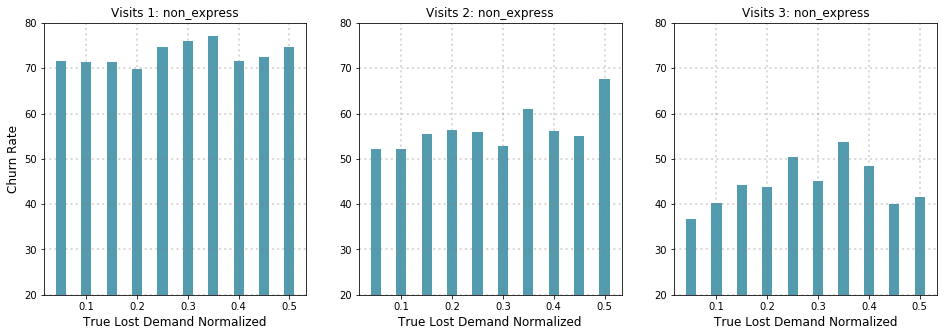

In [36]:
ind_width = 0.02
t_type = 2
variable = 'lost_true_d_visit'
x_label = 'True Lost Demand Normalized'

fig = plt.figure(figsize=(16, 5))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

y01, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 1)
           & (df_explore['visit'] < 2)][variable])

y1, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 1)
           & (df_explore['visit'] < 2)][variable])
y1 = [i / float(j) * 100 for i, j in zip(y1, y01)]

ax1 = fig.add_subplot(131)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel(x_label,fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
ax1.set_ylim([20, 80])
ax1.set_title('Visits 1: ' + str(user_type_map_reverse[t_type]))
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

y02, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 2)
           & (df_explore['visit'] < 3)][variable])

y2, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 2)
           & (df_explore['visit'] < 3)][variable])
y2 = [i / float(j) * 100 for i, j in zip(y2, y02)]

ax2 = fig.add_subplot(132)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel(x_label,fontsize=12)
ax2.set_ylim([20, 80])
ax2.set_title('Visits 2: ' + str(user_type_map_reverse[t_type]))
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

y03, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 3)
           & (df_explore['visit'] < 4)][variable])

y3, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 3)
           & (df_explore['visit'] < 4)][variable])
y3 = [i / float(j) * 100 for i, j in zip(y3, y03)]

ax3 = fig.add_subplot(133)
ax3.bar(x, y3, align='center', color='#539caf', width=ind_width)
ax3.set_xlabel(x_label,fontsize=12)
ax3.set_ylim([20, 80])
ax3.set_title('Visits 3: ' + str(user_type_map_reverse[t_type]))
ax3.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Customer Implicit Churn Rate '\
            + str(user_type_map_reverse[t_type]) + '.png')
plt.show()

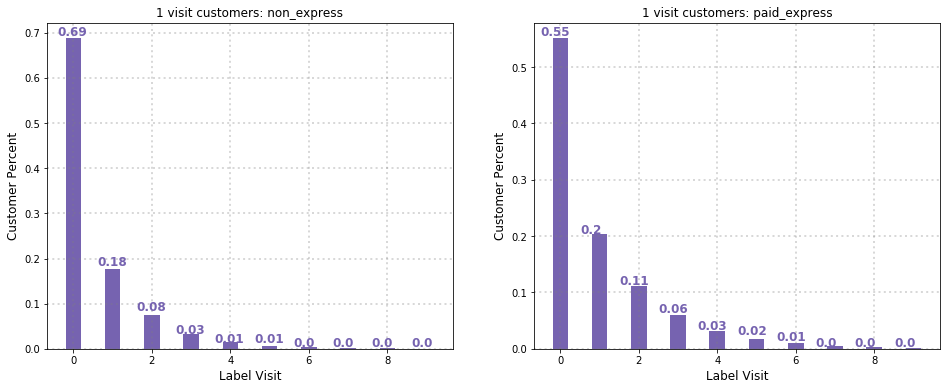

In [37]:
t_user_type = 2
x = [0,1,2,3,4,5,6,7,8,9]

tot = len(df_explore[(df_explore['user_type'] == t_user_type)\
           & (df_explore['visit'] == 1)])
count, bins = np.histogram(df_explore[(df_explore['user_type'] == t_user_type)\
           & (df_explore['visit'] == 1)\
           & (df_explore['label_visit'] < 10)]['label_visit'])
y = [i / float(tot) for i in count]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x, y, align='center', color='#7663b0', width=0.4)
ax1.set_xlabel('Label Visit',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('1 visit customers: ' + user_type_map_reverse[t_user_type])
for i, v in enumerate(y):
    ax1.text(i - 0.4, round(v, 2) + 0.005, str(round(v,2)), color='#7663b0', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)


t_user_type2 = 5
tot2 = len(df_explore[(df_explore['user_type'] == t_user_type2)\
           & (df_explore['visit'] == 1)])
count2, bins = np.histogram(df_explore[(df_explore['user_type'] == t_user_type2)\
           & (df_explore['visit'] == 1)\
           & (df_explore['label_visit'] < 10)]['label_visit'])
y2 = [i / float(tot2) for i in count2]

ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#7663b0', width=0.4)
ax2.set_xlabel('Label Visit',fontsize=12)
ax2.set_ylabel('Customer Percent',fontsize=12)
for i, v in enumerate(y2):
    ax2.text(i - 0.5, round(v, 2) + 0.005, str(round(v,2)), color='#7663b0', fontweight='bold', fontsize=12)
ax2.set_title('1 visit customers: ' + user_type_map_reverse[t_user_type2])
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

#### Explore for non_express visit 1-3 users has more smaller lost_true_d_visit

325503 customers have 1-3 visits and 208805 customers have 4-6 visits.


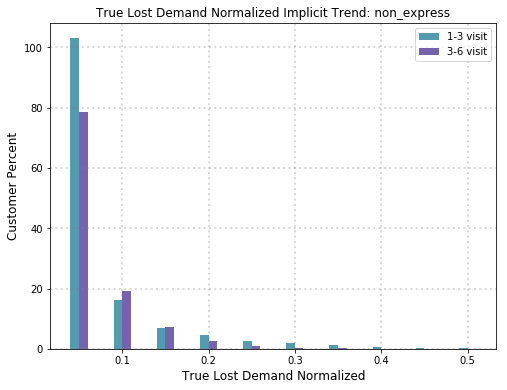

In [38]:
ind_width = 0.01

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

t_type = 2

tot_1 = len(df_explore[(df_explore['user_type'] == t_type)\
                       & (df_explore['visit'] >= 1)\
                 & (df_explore['visit'] < 3) & (df_explore['lost_true'].notnull())])
y1, division1 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
                                  & (df_explore['visit'] >= 1)\
                                  & (df_explore['visit'] < 3)\
                                  & (df_explore['lost_d_visit'] <= 0.5)]['lost_d_visit'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(df_explore[(df_explore['user_type'] == t_type)\
                       & (df_explore['visit'] >= 3)\
                 & (df_explore['visit'] < 6) & (df_explore['lost_true'].notnull())])
y2, division2 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
                                  & (df_explore['visit'] >= 3)\
                                  & (df_explore['visit'] < 6)\
                                  & (df_explore['lost_d_visit'] <= 0.5)]['lost_d_visit'])
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='1-3 visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='3-6 visit', width=ind_width)
ax1.set_xlabel('True Lost Demand Normalized',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('True Lost Demand Normalized Implicit Trend: '\
              + user_type_map_reverse[t_type])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

if True:
    plt.savefig('20180903-20180930 True Lost Demand Normalized Implicit Trend: '
            + user_type_map_reverse[t_type] + '.png')
print('%6d customers have 1-3 visits and %6d customers have 4-6 visits.'%(tot_1, tot_2))
plt.show()

### Explore zone region difference

In [39]:
df_explore.head(3)

,user_id,lost_estimate,order,visit,warehouse_daily_avg,visit_interval,num_warehouse,user_type,lost_lag,visit_lost,lost_true,lost_true_scale,lost_d_visit,lost_true_d_visit,lost_true_scale_d_visit,label_visit,label_order
0,11,0.060055,1.0,1,1.000000,28.0,1,2,0.002145,NaN,NaN,NaN,0.060055,NaN,NaN,0.0,0.0
1,22,0.209654,1.0,6,3.333333,2.5,13,3,0.028181,6.0,0.209654,8.0,0.034942,0.034942,1.333333,5.0,0.0
2,52,0.000000,0.0,1,1.000000,28.0,1,2,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,2.0,0.0


In [40]:
data_sf = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'] == 1].user_id.tolist())]\
                     .copy()
data_sf['label'] = data_sf['label_visit'] - data_sf['visit']
data_miami = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'] == 79].user_id.tolist())]\
                     .copy()
data_miami['label'] = data_miami['label_visit'] - data_miami['visit']
data_manhattan = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'].isin([18, 27])].user_id.tolist())]\
                     .copy()
data_manhattan['label'] = data_manhattan['label_visit'] - data_manhattan['visit']
data_la = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'].isin([972, 983, 1002])].user_id.tolist())]\
                     .copy()
data_la['label'] = data_la['label_visit'] - data_la['visit']

In [41]:
print('Total %6d users in SF, and %6d users in Miami.'%(len(data_sf), len(data_miami)))
print('Total %6d users in Manhattan, and %6d users in LA.'%(len(data_manhattan), len(data_la)))
print('Total %6d non_express in SF, and %6d non_express in Miami.'\
      %(len(data_sf[data_sf['user_type'] == 2]), len(data_miami[data_miami['user_type'] == 2])))
print('Total %6d non_express in SF, and %6d non_express in Miami.'\
      %(len(data_sf[data_sf['user_type'] == 5]), len(data_miami[data_miami['user_type'] == 5])))

Total  35297 users in SF, and  19201 users in Miami.
Total  41686 users in Manhattan, and  61650 users in LA.
Total  20041 non_express in SF, and  11301 non_express in Miami.
Total  11676 non_express in SF, and   6353 non_express in Miami.


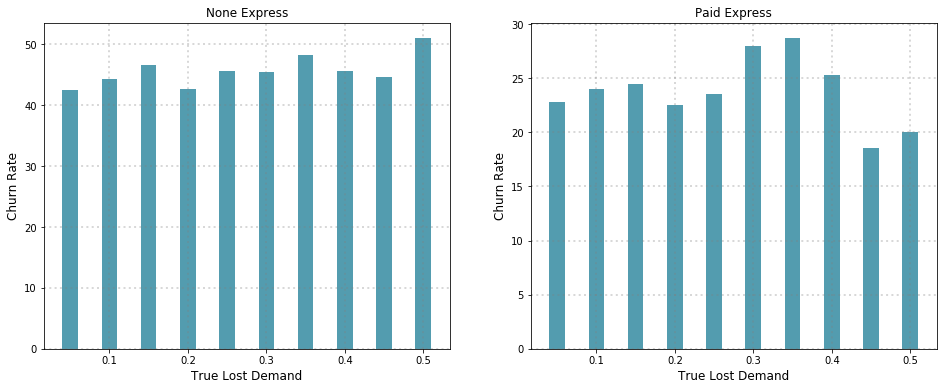

In [42]:
t_df = data_manhattan
ind_width = 0.02
lower = 2
upper = 5
variable = 'lost_true'
x_label = 'True Lost Demand'

fig = plt.figure(figsize=(16, 6))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

t_type1 = 2
y0, division0 = np.histogram(t_df[(t_df['user_type'] == t_type1)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])

y1, division1 = np.histogram(t_df[(t_df['label_visit'] == 0)\
           & (t_df['user_type'] == t_type1)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])
y1 = [i / float(j) * 100 for i, j in zip(y1, y0)]

ax1 = fig.add_subplot(121)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel(x_label, fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
#ax1.set_ylim([0, 80])
ax1.set_title('None Express')
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

t_type2 = 5
y, division = np.histogram(t_df[(t_df['user_type'] == t_type2)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])

y3, division3 = np.histogram(t_df[(t_df['label_visit'] == 0)\
           & (t_df['user_type'] == t_type2)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])
y3 = [i / float(j) * 100 for i, j in zip(y3, y)]

ax2 = fig.add_subplot(122)
ax2.bar(x, y3, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel(x_label,fontsize=12)
ax2.set_ylabel('Churn Rate',fontsize=12)
ax2.set_title('Paid Express')
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost Deliveries vs Churn  '\
            + str(lower) + '_' + str(upper) + '_Manhattan.png')
plt.show()

  1565 is +1 Delta Visit and   2570 is -1 Delta Visit.


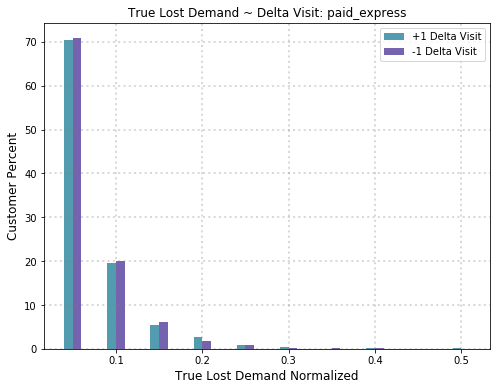

In [43]:
ind_width = 0.01

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

t_type = 5
t_df = data_sf[data_sf['user_type'] == t_type].copy()
lower_bound = 1
upper_bound = 3

tot_1 = len(t_df[(t_df['label'] >= lower_bound)\
                 & (t_df['label'] < upper_bound) & (t_df['lost_true'].notnull())])
y1, division1 = np.histogram(t_df[(t_df['label'] >= lower_bound)\
                                  & (t_df['label'] < upper_bound)\
                                  & (t_df['lost_true_d_visit'] <= 0.5)]['lost_true_d_visit'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(t_df[(t_df['label'] >= -1 * upper_bound)\
                 & (t_df['label'] < -1 * lower_bound) & (t_df['lost_true'].notnull())])
y2, division2 = np.histogram(t_df[(t_df['label'] >= -1 * upper_bound)\
                                  & (t_df['label'] < -1 * lower_bound)\
                                  & (t_df['lost_true_d_visit'] <= 0.5)]['lost_true_d_visit'])
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='+'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='-'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.set_xlabel('True Lost Demand Normalized',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('True Lost Demand ~ Delta Visit: '\
              + user_type_map_reverse[t_type])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost For Different Delta Visit '\
            + user_type_map_reverse[t_type]\
            + '_' + str(lower_bound) + '_' \
            + str(upper_bound) + '_SF.png')
print('%6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(tot_1, tot_2))
plt.show()

### Explore correlation

In [44]:
# sm.OLS() Can Fit Negative Line?

for u_type in [5]:
    
    train_X = df_explore[df_explore['user_type'] == u_type]['visit']
    train_y = df_explore[df_explore['user_type'] == u_type]['label_visit']
    X2 = sm.add_constant(train_X)
    est = sm.OLS(train_y, X2)
    est2 = est.fit()
    print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            label_visit   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 5.071e+05
Date:                Tue, 19 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:48:47   Log-Likelihood:            -8.5902e+05
No. Observations:              344277   AIC:                         1.718e+06
Df Residuals:                  344275   BIC:                         1.718e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1087      0.008     13.148      0.0

## Feature Engineering For User Infos

In [45]:
def get_email_type(x):
    
    m = re.search(r'(\S+)@(\S+)', x)
    
    return m.group(2)

if False:
    user_infos['email_type'] = user_infos['email'].map(lambda x: get_email_type(x))
    
user_infos['has_phone'] = user_infos['phone'].notnull().map(lambda x: 1 if x else 0)

user_infos.rename(columns={'id':'user_id'}, inplace=True)
user_infos = user_infos.merge(user_ids, on=['user_id'])
user_infos['life_days'] = (user_infos['last_date'] - user_infos['created_at']).map(lambda x: x.days) 

user_info_df = user_infos[['user_id', 'has_phone', 'gender',\
                           'receive_emails', 'life_days']].copy()

In [46]:
user_infos.head(3)

,user_id,name,email,phone,became_express_member_on,sign_in_count,active,gender,receive_emails,household_income,...,converted_from_id,converted_to_id,first_name,last_name,created_at,has_phone,first_date,last_date,label_date,life_days
0,35322,Meredith Zappert,meredith.story@gmail.com,4109910716,NaT,74,True,female,True,None,...,NaN,None,Meredith,Zappert,2013-07-03 19:25:09.000000,1,2018-09-04,2018-10-02,2018-10-30,1916
1,38936,Yi,zhengyi8341@gmail.com,6503538692,NaT,10,True,male,False,None,...,NaN,None,Yi,None,2013-07-24 03:12:22.000000,1,2018-09-16,2018-10-14,2018-11-11,1907
2,71321,None,jentosic@sbcglobal.net,7734809198,NaT,5,True,None,True,None,...,NaN,None,Jen,Kudesh,2013-12-06 01:15:12.625791,1,2018-09-04,2018-10-02,2018-10-30,1760


In [47]:
user_infos.isnull().sum()

user_id                           0
name                        1427542
email                             0
phone                        612482
became_express_member_on    2046006
sign_in_count                     0
active                            0
gender                      1885066
receive_emails                    0
household_income            2045741
occupation                  2046059
vip                               0
orders_count                      0
twilio_number_id             795699
fraud_kind                  1544687
phone_type                  2024785
phone_provider              2039727
deleted_ind                       0
converted_from_id           2046082
converted_to_id             2043533
first_name                        0
last_name                    154761
created_at                        0
has_phone                         0
first_date                        0
last_date                         0
label_date                        0
life_days                   

## Model Train

Features considered: 'lost_estimate', 'visit', 'has_phone', 'life_days', 'gender_male', 'gender_female', 'warehouse_daily_avg', 'receive_emails', 'life_days'

In [48]:
df = user_df.merge(user_info_df, on=['user_id'])
df = df.merge(label_df, on=['user_id'])
df['gender'] = df['gender'].map(lambda x: 'male' if x == 'male (hidden)'\
                                else 'female' if x == 'female (hidden)' else x)
df = df.join(pd.get_dummies(df.gender, prefix='gender'))
df['receive_emails'] = df['receive_emails'].map(lambda x: 1 if x else 0)
df.rename(columns={"gender_female (hidden)":"gender_female_hidden",\
                   "gender_male (hidden)":"gender_male_hidden"}, inplace=True)

In [49]:
df.columns

Index([                u'user_id',           u'lost_estimate',
                         u'order',                   u'visit',
           u'warehouse_daily_avg',          u'visit_interval',
                 u'num_warehouse',               u'user_type',
                      u'lost_lag',              u'visit_lost',
                     u'lost_true',         u'lost_true_scale',
                  u'lost_d_visit',       u'lost_true_d_visit',
       u'lost_true_scale_d_visit',               u'has_phone',
                        u'gender',          u'receive_emails',
                     u'life_days',             u'label_visit',
                   u'label_order',           u'gender_female',
                   u'gender_male'],
      dtype='object')

## Explore Correlation Between Features

  - For Non-express:
    - lost = 2.38 + 6.96 * visit, R^2 = 0.22
    - lost = 0.86 + 2.86 * order, R^2 = 0.14
    - lost = 20.2 - 16.9 * visit_interval, R^2 = 0.15
    - lost = 1.40 + 2.11 * num_warehouse, R^2 = 0.10
    - lost = 1.22 + 0.49 * warehouse_daily_avg, R^2 = 0.03
    
    
  - For Paid-express:
    - lost = 4.47 + 7.24 * visit, R^2 = 0.23
    - lost = 2.37 + 3.32 * order, R^2 = 0.14
    - lost = 14.5 - 9.90 * visit_interval, R^2 = 0.14
    - lost = 1.75 + 2.67 * num_warehouse, R^2 = 0.19
    - lost = 1.26 + 0.54 * warehouse_daily_avg, R^2 = 0.09

In [50]:
t_type = 5
corr_X = df[df['user_type'] == t_type]['visit']
corr_y = df[df['user_type'] == t_type]['label_visit']

X1 = sm.add_constant(corr_X)
est = sm.OLS(corr_y, X1)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            label_visit   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 5.071e+05
Date:                Tue, 19 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:49:10   Log-Likelihood:            -8.5902e+05
No. Observations:              344277   AIC:                         1.718e+06
Df Residuals:                  344275   BIC:                         1.718e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1087      0.008     13.148      0.0

## Get DataFrame Ready For Modeling

In [51]:
# Get train, test and predict DataFrame
user_type_model = 2 # [1, 2, 3, 5]. Not Working for 4, too few records.
    
data = df[(df['user_type'] == user_type_model)\
          & (df['lost_true_scale_d_visit'].notnull())].copy().reset_index().\
                         drop(['index', 'user_id', 'gender'], axis=1)
data['label'] = data['label_order'] - data['order']
data_Y = data['label'].copy()

# Get useful mean() and std().
order_std = data['order'].std()
order_mean = data['order'].mean()
lost_true_scale_d_visit_mean = data['lost_true_scale_d_visit'].mean()
lost_true_scale_d_visit_std = data['lost_true_scale_d_visit'].std()

# Normalize Features
data = (data - data.mean()) / data.std()

data_train, data_test, train_y, test_y = train_test_split(data, data_Y, test_size=.1)

### Exam any relationship

#### Control for 'label'

  5452 is +1 Delta Visit and  16784 is -1 Delta Visit.


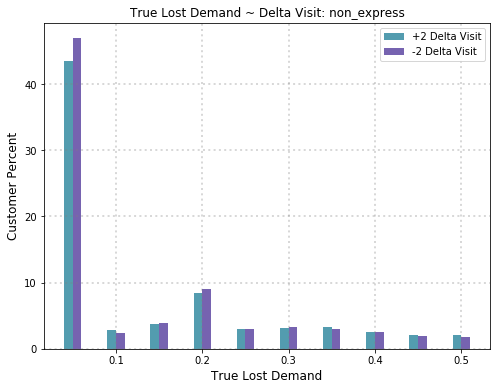

In [52]:
ind_width = 0.01

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

lower_bound = 2
upper_bound = 3

tot_1 = len(data[(data['label'] >= lower_bound)\
                 & (data['label'] < upper_bound) & (data['lost_true'].notnull())])
y1, division1 = np.histogram(data[(data['label'] >= lower_bound)\
                                  & (data['label'] < upper_bound)\
                                  & (data['lost_true'] <= 0.5)]['lost_true'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(data[(data['label'] >= -1 * upper_bound)\
                 & (data['label'] < -1 * lower_bound) & (data['lost_true'].notnull())])
y2, division2 = np.histogram(data[(data['label'] >= -1 * upper_bound)\
                                  & (data['label'] < -1 * lower_bound)\
                                  & (data['lost_true'] <= 0.5)]['lost_true'])
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='+'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='-'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.set_xlabel('True Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('True Lost Demand ~ Delta Visit: '\
              + user_type_map_reverse[user_type_model])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

if False:
    plt.savefig('20180903-20180930 Lost For Different Delta Visit '\
            + user_type_map_reverse[user_type_model]\
            + '_' + str(lower_bound) + '_' \
            + str(upper_bound) + '.png')
print('%6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(tot_1, tot_2))
plt.show()

 81560 is +1 Delta Visit and  67693 is -1 Delta Visit.


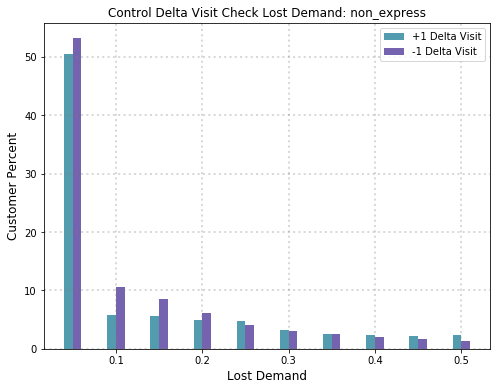

In [53]:
ind_width = 0.01

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

lower_bound = 1
upper_bound = 3

tot_1 = len(data[(data['label'] >= lower_bound)\
                 & (data['label'] < upper_bound) & (data['lost_true'].notnull())])
y1, division1 = np.histogram(data[(data['label'] >= lower_bound)\
                                  & (data['label'] < upper_bound)\
                                  & (data['lost_true_d_visit'] <= 0.5)]['lost_true_d_visit'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(data[(data['label'] >= -1 * upper_bound)\
                 & (data['label'] < -1 * lower_bound) & (data['lost_true'].notnull())])
y2, division2 = np.histogram(data[(data['label'] >= -1 * upper_bound)\
                                  & (data['label'] < -1 * lower_bound)\
                                  & (data['lost_true_d_visit'] <= 0.5)]['lost_true_d_visit'])
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='+'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='-'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Control Delta Visit Check Lost Demand: '\
              + user_type_map_reverse[user_type_model])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost For Different Delta Visit '\
            + user_type_map_reverse[user_type_model]\
            + '_' + str(lower_bound) + '_' \
            + str(upper_bound) + '.png')
print('%6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(tot_1, tot_2))
plt.show()

For visit 1 - 4,  10836 is +1 Delta Visit and  19267 is -1 Delta Visit.


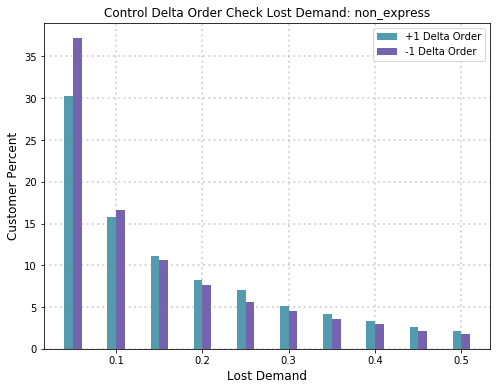

In [54]:
ind_width = 0.01

fig = plt.figure(figsize=(8, 6))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

lower1 = 1
upper1 = 4

tot_1 = len(data[(data['visit'] >= lower1)\
                 & (data['visit'] < upper1)\
                 & (data['lost_true_d_visit'].notnull())\
                 & (data['label'] >= 1)\
                 & (data['label'] < 3)])
y1, division1 = np.histogram(data[(data['visit'] >= lower1)\
                                  & (data['visit'] < upper1)\
                                  & (data['lost_true_d_visit'] <= 0.5)\
                                  & (data['label'] >= 1)\
                                  & (data['label'] < 3)]['lost_true_d_visit'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(data[(data['visit'] >= lower1)\
                 & (data['visit'] < upper1)\
                 & (data['lost_true_d_visit'].notnull())\
                 & (data['label'] >= -3)\
                 & (data['label'] < -1)])
y2, division2 = np.histogram(data[(data['visit'] >= lower1)\
                                  & (data['visit'] < upper1)\
                                  & (data['lost_true_d_visit'] <= 0.5)\
                                  & (data['label'] >= -3)\
                                  & (data['label'] < -1)]['lost_true_d_visit'])
y2 = [i / float(tot_2) * 100 for i in y2]

ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='+1 Delta Order', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='-1 Delta Order', width=ind_width)
ax1.set_xlabel('Lost Demand', fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Control Delta Order Check Lost Demand: '\
              + user_type_map_reverse[user_type_model])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig('20180903-20180930 Lost vs Visit vs Delta Visit '\
            + user_type_map_reverse[user_type_model]\
            + '_' + str(lower1) + '_' \
            + str(upper1) + '_5.1.1.png')
print('For visit %s - %s, %6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(lower1, upper1, tot_1, tot_2))
plt.show()

#### Control For 'lost_true_d_visit'

 15022 is LD 0.1-0.2 and  41620 is lD 0.2-0.5.


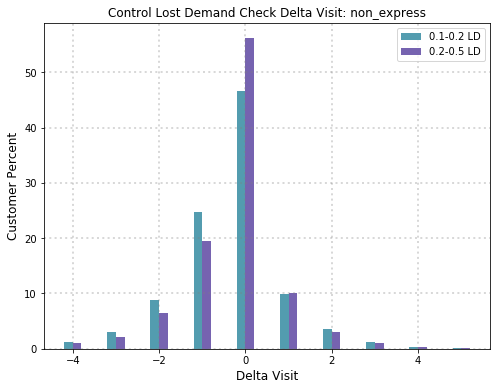

In [55]:
ind_width = 0.2

x = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
x1 = [a - 0.1 for a in x]
x2 = [a + 0.1 for a in x]

tot_1 = len(data[(data['lost_true_d_visit'] >= 0.1 )\
                 & (data['lost_true_d_visit'] < 0.2)])
y1, division1 = np.histogram(data[(data['lost_true_d_visit'] >= 0.1)\
                                  & (data['lost_true_d_visit'] < 0.2)\
                                  & (data['label'] <= 5.5)\
                                  & (data['label'] >= -4.5)]['label'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(data[(data['lost_true_d_visit'] >= 0.2 )\
                 & (data['lost_true_d_visit'] < 0.5)])
y2, division2 = np.histogram(data[(data['lost_true_d_visit'] >= 0.2)\
                                  & (data['lost_true_d_visit'] < 0.5)\
                                  & (data['label'] <= 5.5)\
                                  & (data['label'] >= -4.5)]['label'])
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='0.1-0.2 LD', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='0.2-0.5 LD', width=ind_width)
ax1.set_xlabel('Delta Visit',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Control Lost Demand Check Delta Visit: '\
              + user_type_map_reverse[user_type_model])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

if True:
    plt.savefig('20180903-20180930 Label For Different Lost Demand '\
            + user_type_map_reverse[user_type_model]\
            + '.png')
print('%6d is LD 0.1-0.2 and %6d is lD 0.2-0.5.'%(tot_1, tot_2))
plt.show()

## Modeling

### User Linear Regression

In [56]:
model_type = 'lasso' # 'ridge', 'lasso', 'elasticnet'
include_lost = True
key_feature = 'lost_true_scale_d_visit'

clf_features = ['visit', 'order',\
                'visit_interval', 'num_warehouse',\
                'warehouse_daily_avg',\
                'has_phone', 'gender_male',\
                'gender_female']

if include_lost:
    clf_features = [key_feature] + clf_features
    
train_X = data_train[clf_features].copy()
test_X = data_test[clf_features].copy()

alpha_list = [0.0001, 0.0003, 0.0006, 0.001, 0.003,\
              0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

if model_type == "ridge":
    clf = linear_model.RidgeCV(alphas = alpha_list, cv = 10)
elif model_type == "lasso":
    clf = linear_model.LassoCV(alphas = alpha_list, max_iter = 5000, cv = 10)
elif model_type == "elasticnet":
    clf = linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],\
                                     alphas = alpha_list,\
                                     max_iter = 1000, cv = 3)

clf.fit(train_X, train_y)
predict_y = clf.predict(test_X)

compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

if False:
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
    ax.set_xlabel('Order',fontsize=12)
    ax.set_ylabel('Predict',fontsize=12)
    ax.set_title('%s Result'%(model_type))
    plt.savefig('20180903-20180930 LassoCV Result.png')
    plt.show()
    
print('Mean Squared Error %.2f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

/Users/jianhuitian/.virtualenvs/staffing/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


Mean Squared Error 1.01.
Mean Absolute Error 0.63.
Actual mean -0.335, predict mean -0.336


In [57]:
print('Regularization %.2f.\n'%(clf.alpha_))
coef_dict = {}
for coef, feat in zip(clf.coef_, clf_features):
    coef_dict[feat] = round(coef, 3)

print('%s %s:\n'%(model_type, user_type_map_reverse[user_type_model]))
print(coef_dict)

Regularization 0.00.

lasso non_express:

{'visit_interval': 0.078, 'has_phone': 0.007, 'visit': 0.18, 'warehouse_daily_avg': 0.01, 'gender_female': 0.001, 'num_warehouse': -0.03, 'gender_male': -0.006, 'lost_true_scale_d_visit': 0.024, 'order': -0.675}


#### Estimate Lost Demand Impact

Get deltaOrder for 0.1, 0.2, 0.3, 0.4, 0.5 deltaLD.

In [58]:
dict_predict = {}
if include_lost: 
    deltaLD_d = []
    t_std = lost_true_scale_d_visit_std
    delta_list = [0, 0.4, 0.8, 1.2, 1.6, 2.0]
    for deltaLD in delta_list:

        # Add deltaLD   
        t = []
        t_l = [0 for i in range(len(clf_features) - 1)]
        for i in range(len(test_X)):
            t.append([deltaLD / t_std] + t_l)
        X2 = np.add(test_X, np.array(t))

        t_predict = clf.predict(X2)
        #print(X2[['lost_estimate', 'visit']].head(1))
        dict_predict[deltaLD] = t_predict
        deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                          round(np.mean(t_predict), 3)))

    print("deltaLD , order_mean, predicted_mean")
    for i in range(len(deltaLD_d)):
        print(deltaLD_d[i])
        
print(coef_dict)

# Normalized the change by visits of customers.
df_impact_norm = pd.DataFrame(dict_predict)
df_impact_norm = df_impact_norm.assign(order=test_X['order'].tolist())
df_impact_norm['order'] = df_impact_norm['order'].map(lambda x: round(x * order_std + order_mean, 1))
df_impact_norm['deltaOrder'] = (df_impact_norm[delta_list[-1]] - df_impact_norm[0]) / df_impact_norm['order']
print('\nMean is %.3f, normalized delta Order for delta LD is %.3f.'\
      %(np.mean(df_impact_norm[0]),\
        np.mean(df_impact_norm[df_impact_norm['order'] != 0]['deltaOrder'])))

deltaLD , order_mean, predicted_mean
(0, -0.335, -0.336)
(0.4, -0.335, -0.328)
(0.8, -0.335, -0.319)
(1.2, -0.335, -0.311)
(1.6, -0.335, -0.303)
(2.0, -0.335, -0.294)
{'visit_interval': 0.078, 'has_phone': 0.007, 'visit': 0.18, 'warehouse_daily_avg': 0.01, 'gender_female': 0.001, 'num_warehouse': -0.03, 'gender_male': -0.006, 'lost_true_scale_d_visit': 0.024, 'order': -0.675}

Mean is -0.336, normalized delta Order for delta LD is 0.029.


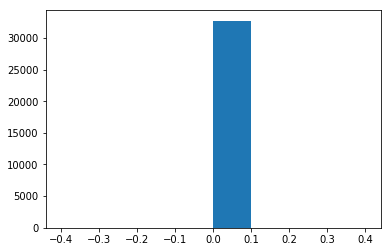

In [59]:
b = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
c, b, f = plt.hist(df_impact_norm.deltaOrder, bins=b)
plt.show()

### Use statsmodel

In [60]:
# Use the same train_X and test_X as Lasso.

X2 = sm.add_constant(train_X)
est = sm.OLS(train_y, X2)
est2 = est.fit()
# print(clf_features)
print(est2.summary())

X2 = sm.add_constant(test_X)
predict_y = est2.predict(X2)
print('\nMean Squared Error %.2f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                 2.436e+04
Date:                Tue, 19 Feb 2019   Prob (F-statistic):               0.00
Time:                        10:49:16   Log-Likelihood:            -8.1468e+05
No. Observations:              574965   AIC:                         1.629e+06
Df Residuals:                  574955   BIC:                         1.630e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Estimate Lost Demand Impact

In [61]:
if include_lost: 
    deltaLD_d = []
    t_std = lost_true_scale_d_visit_std
    delta_list = [0, 0.4, 0.8, 1.2, 1.6, 2.0]
    for deltaLD in delta_list:

        # Add deltaLD   
        t = []
        t_l = [0 for i in range(len(clf_features) - 1)]
        for i in range(len(test_X)):
            t.append([deltaLD / t_std] + t_l)
        X2 = np.add(test_X, np.array(t))

        X2 = sm.add_constant(X2)
        t_predict = est2.predict(X2)
        #print(X2[['lost_estimate', 'visit']].head(1))
        deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                          round(np.mean(t_predict), 3)))

    print("deltaLD , order_mean, predicted_mean")
    for i in range(len(deltaLD_d)):
        print(deltaLD_d[i])
        
    print(clf_features)

deltaLD , order_mean, predicted_mean
(0, -0.335, -0.336)
(0.4, -0.335, -0.328)
(0.8, -0.335, -0.319)
(1.2, -0.335, -0.311)
(1.6, -0.335, -0.303)
(2.0, -0.335, -0.294)
['lost_true_scale_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female']


### Use Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor
import datetime
now = datetime.datetime.now()

filename = 'random_forest_' + str(user_type_map_reverse[user_type_model]) + '_'\
    + str(now.date()) + '-' + str(now.hour) + '.sav'

if False:
    rf = RandomForestRegressor(n_jobs=-1) 

    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }

    grid = GridSearchCV(estimator=rf, param_grid=params_grid, cv=4)

    grid.fit(train_X, train_y)

    predict_y = grid.best_estimator_.predict(test_X)

    compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

    if False:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
        ax.set_xlabel('Order',fontsize=12)
        ax.set_ylabel('Predict',fontsize=12)
        ax.set_title('Random Forest Result')
        # ax.legend(loc = 'upper right', fontsize=10)
        plt.savefig('20180903-20180930 Random Forest Result.png')
        plt.show()
    
    print(grid.best_params_)
    pickle.dump(grid, open(filename, 'wb'))
    
    print('Mean Squared Error %.3f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
    print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
    print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

#### Estimate Lost Deliveries Impact

The saved models:

- random_forest_paid_express_2019-02-18-7.sav:
  - 'lost_true_scale_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female'
  
  
- random_forest_non_express_2019-02-17-21.sav:
  - 'lost_true_scale_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female'

In [63]:
print(clf_features)

['lost_true_scale_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female']


In [64]:
dict_predict2 = {}

if True:
    filename = 'random_forest_non_express_2019-02-17-21.sav'
    if include_lost:
        # load the model from disk
        grid = pickle.load(open(filename, 'rb'))

        deltaLD_d = []
        t_std = lost_true_scale_d_visit_std
        delta_list = [0, 0.4, 0.8, 1.2, 1.6, 2.0]
        for deltaLD in delta_list:

            # Add deltaLD   
            t = []
            t_l = [0 for i in range(len(clf_features) - 1)]
            for i in range(len(test_X)):
                t.append([deltaLD / t_std] + t_l)
            X2 = np.add(test_X, np.array(t))

            t_predict = grid.best_estimator_.predict(X2)
            dict_predict2[deltaLD] = t_predict
            #print(X2[['lost_estimate', 'visit']].head(1))
            deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                              round(np.mean(t_predict), 3)))

        print("deltaLD , order_mean, predicted_mean")
        for i in range(len(deltaLD_d)):
            print(deltaLD_d[i])
        
    grid = pickle.load(open(filename, 'rb'))
    predict_y = grid.best_estimator_.predict(test_X)
    print('Mean Squared Error %.3f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
    print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
    print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))
    
# Normalized the change by visits of customers.
df_impact_norm2 = pd.DataFrame(dict_predict2)
df_impact_norm2 = df_impact_norm2.assign(order=test_X['order'].tolist())
df_impact_norm2['order'] = df_impact_norm2['order'].map(lambda x: round(x * order_std + order_mean, 1))
df_impact_norm2['deltaOrder'] = (df_impact_norm2[delta_list[-1]] - df_impact_norm2[0]) / df_impact_norm2['order']
print('\nMean is %.3f, normalized delta Order for delta LD is %.3f.'\
      %(np.mean(df_impact_norm2[0]),\
        np.mean(df_impact_norm2[df_impact_norm2['order'] != 0]['deltaOrder'])))

deltaLD , order_mean, predicted_mean
(0, -0.335, -0.337)
(0.4, -0.335, -0.327)
(0.8, -0.335, -0.322)
(1.2, -0.335, -0.313)
(1.6, -0.335, -0.304)
(2.0, -0.335, -0.294)
Mean Squared Error 0.974.
Mean Absolute Error 0.63.
Actual mean -0.335, predict mean -0.337

Mean is -0.337, normalized delta Order for delta LD is 0.034.


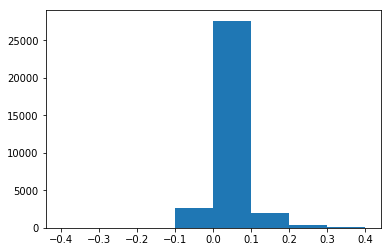

In [65]:
b = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
c, b, f = plt.hist(df_impact_norm2.deltaOrder, bins=b)
plt.show()

### Plot Lost Demand Impact

In [66]:
if False:
    # With random_forest_paid_express_2019-02-14-23.sav:
    ['lost_true_scale_d_visit', 'visit', 'order', 'visit_interval',\
    'num_warehouse', 'warehouse_daily_avg', 'has_phone',\
    'gender_male', 'gender_female']

    user_type = 'Paid Express'
    deltaLD = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
    LR_result = [-1.392, -1.399, -1.405, -1.412, -1.419, -1.425]
    RF_result = [-1.393, -1.394, -1.394, -1.396, -1.40, -1.405]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(deltaLD, LR_result, 'go-', label='LR', linewidth=2, color='#539caf')
    ax.plot(deltaLD, RF_result, 'go-', label='RF', linewidth=2, color='#7663b0')
    ax.set_xlabel('Delta LD', fontsize=12)
    ax.set_ylabel('Label', fontsize=12)
    ax.legend(loc = 'lower left',fontsize=12)
    #ax.set_ylim([0,3])
    ax.set_title('Lost Demand Impact: ' + user_type)
    plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    plt.savefig('20180903-20180930 Paid Express Lost Delivery Impact 2.png')
    plt.show()

In [67]:
if False:
    # With random_forest_non_express_2019-02-14-18.sav:
    ['lost_true_scale_d_visit', 'visit', 'order', 'visit_interval',\
    'num_warehouse', 'warehouse_daily_avg', 'has_phone',\
    'gender_male', 'gender_female']

    user_type = 'None Express'
    deltaLD = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
    LR_result = [-1.772, -1.779, -1.786, -1.793, -1.8, -1.807]
    RF_result = [-1.771, -1.781, -1.793, -1.808, -1.823, -1.837]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(deltaLD, LR_result, 'go-', label='LR', linewidth=2, color='#539caf')
    ax.plot(deltaLD, RF_result, 'go-', label='RF', linewidth=2, color='#7663b0')
    ax.set_xlabel('Delta LD', fontsize=12)
    ax.set_ylabel('Label', fontsize=12)
    ax.legend(loc = 'lower left',fontsize=12)
    #ax.set_ylim([0,3])
    ax.set_title('Lost Demand Impact: ' + user_type)
    plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    plt.savefig('20180903-20180930 None Express Lost Delivery Impact 2.png')
    plt.show()

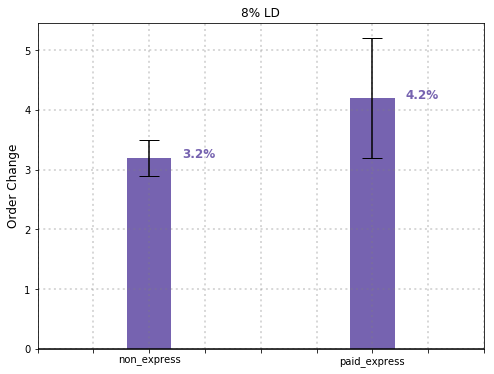

In [68]:
df_impact = pd.DataFrame({'change':[3.2, 4.2], 'std':[0.3, 1.0]})
ind_width = 0.2

fig, ax = plt.subplots(figsize=(8,6))
ax.bar([1, 2], df_impact['change'], align='center', color='#7663b0',\
       yerr=df_impact['std'], capsize=10, width=ind_width)
ax.plot([i * 0.2 for i in range(20)], [0 for i in range(20)], color='black')
ax.set_ylabel('Order Change',fontsize=12)
ax.set_title('8% LD')
ax.set_xlim([0.5, 2.5])
for i, v in enumerate(df_impact['change']):
    ax.text(i + 1.15, v - 0.001, str(v) + '%', color='#7663b0', fontweight='bold', fontsize=12)
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.set_xticklabels(('', '', 'non_express', '', '', '', 'paid_express'))
plt.savefig('20180903-20180930 Lost Demand Impact Final 5.1.1.png')
plt.show()